# Movie Ratings Network

this notebook is used to create the movie networks based on the ratings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = 'datasets/'

In [2]:
# Load data
ratings = pd.read_csv(DATA_PATH+'ml-100k-convert/data.tsv', sep='\t', names=['UserId', 'MovieId', 'Ratings', 'Timestamp'])
print(ratings.shape)
ratings.head()

(100000, 4)


,UserId,MovieId,Ratings,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
# Load the movie id
movies = pd.read_csv(DATA_PATH+'final_movies.csv')
movies_id = movies['ML-100k-convertId'].to_list()

In [8]:
ratings = ratings[ratings.MovieId.isin(movies_id)]
ratings

,UserId,MovieId,Ratings,Timestamp
1,186,302,3,891717742
3,244,51,2,880606923
4,166,346,1,886397596
6,115,265,2,881171488
8,305,451,3,886324817
...,...,...,...,...
99991,676,538,4,892685437
99992,721,262,3,877137285
99995,880,476,3,880175444
99996,716,204,5,879795543


In [9]:
nb_users = len(ratings.UserId.unique())
nb_movies = len(ratings.MovieId.unique())
print('There are {} users'.format(nb_users))
print('There are {} movies'.format(nb_movies))

There are 943 users
There are 480 movies


In [10]:
# Get rid of timestamp
ratings = ratings.drop(columns=['Timestamp'])
# Pivot the table, put 0 when there are no ratings
ratings = pd.pivot_table(ratings, index='UserId', columns='MovieId', values='Ratings', fill_value=0)
ratings

MovieId,1,2,3,4,5,8,9,10,11,12,...,1514,1525,1526,1530,1547,1615,1651,1654,1664,1680
UserId,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,1,5,3,2,5,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,5,3,0,0,4,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
ratings[ratings > 0].count(axis=1)

UserId
1      161
2       36
3       36
4       16
5       87
      ... 
939     31
940     69
941     16
942     52
943    113
Length: 943, dtype: int64

To compute the distance between two movies we look at all gradings they gets from the same people. We compute the mean square difference between the grades given for the movies and use it as a distance between the movies.

Note: we do have to consider the bias introduced by the user as we compute the difference between gradings coming from the same users.

In [17]:
def movie_distance(ratingsA, ratingsB):
    diff_ratings = []
    for x, y in zip(ratingsA, ratingsB):
        if x != 0 and y != 0:
            diff_ratings.append(x - y)
    if diff_ratings:
        return np.linalg.norm(diff_ratings, 2)/np.sqrt(len(diff_ratings))
    else:
        return np.inf

In [18]:
distance_matrix = np.ndarray(shape=(nb_movies, nb_movies))

In [19]:
for i, idx in enumerate(ratings.columns):
    for j, idy in enumerate(ratings.columns):
        distance_matrix[i, j] = movie_distance(ratings[idx].to_list(), ratings[idy].to_list())
        distance_matrix[j, i] = distance_matrix[i, j]

In [20]:
distance_matrix[:5, :5]

array([[0.        , 1.33373391, 1.59727332, 1.32857091, 1.18469776],
       [1.33373391, 0.        , 1.3826658 , 1.26491106, 1.13898959],
       [1.59727332, 1.3826658 , 0.        , 1.60623784, 1.11269728],
       [1.32857091, 1.26491106, 1.60623784, 0.        , 1.6686263 ],
       [1.18469776, 1.13898959, 1.11269728, 1.6686263 , 0.        ]])

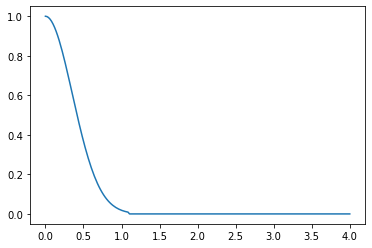

In [22]:
dist = np.linspace(0, 4, 200)
alpha = 0.25
epsilon = 1.1
weight = np.exp(- dist ** 2 / alpha)
weight[dist > 1.1] = 0
plt.plot(dist, weight)

In [23]:
def epsilon_similarity_graph(X: np.ndarray, alpha=1, epsilon=0):
    """ X (n x d): distance matrix
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    X[X > epsilon] = np.inf
    adjacency = np.exp( - X ** 2 / alpha)
    np.fill_diagonal(adjacency, 0)
    return adjacency

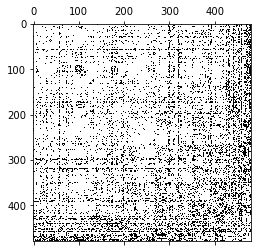

In [24]:
adjacency = epsilon_similarity_graph(distance_matrix, alpha=0.25, epsilon=1.1)
plt.spy(adjacency)
plt.show()

In [25]:
np.savetxt(DATA_PATH+'movie_ratings_adj.csv', adjacency, delimiter=',')

In [26]:
import networkx as nx

graph = nx.from_numpy_array(adjacency)
nx.write_gexf(graph, 'movie_ratings.gexf')

In [27]:
ratings.to_csv(DATA_PATH+'ratings_matrix.csv')